# ONLINE SHOPPING INTENTION ANALYSIS - EXPLORATION ANALYSIS AND ML PREDICTION

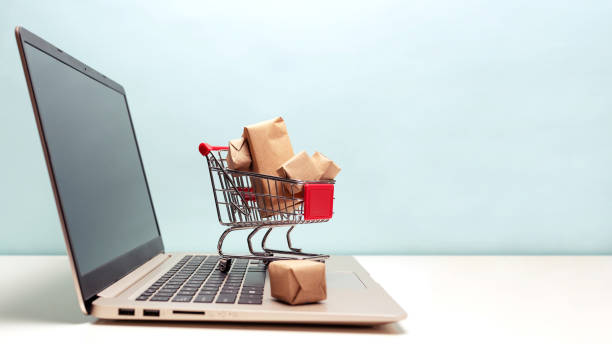

### This notebook features exploration analysis and implementation of following ML models : PCA (Principal Component Analysis) for Dimensionality Reduction, Logistic Regression, Random Forest, and Keras Deep Learning Sequential Model for Classification. The models will be tuned using GridSearchCV. Keras model will be tuned by GridSearchCV while using Keras wrapper for ScikitLearn .



In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc, plot_cumulative_gain
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

In [2]:
data=pd.read_csv('../input/online-shoppers-purchasing-intention-dataset/online_shoppers_intention.csv')

In [3]:
#We will define some functions which will be helpful later

def categorical_analysis(var, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.countplot(data=data, x=var, **kwargs, ax=axes[0])
    crossed=pd.crosstab(data[var], data.Revenue, normalize=0).unstack().reset_index().rename(columns={0:'Percentage'})
    crossed.loc[crossed.Revenue==False,'Percentage']=1
    sns.barplot(data=crossed, x=var, y='Percentage', hue='Revenue', ax=axes[1], **kwargs, dodge=False)
    axes[1].set_title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()   
    print('\n CHI SQUARE TEST \n')
    p_value=chi2_contingency(pd.crosstab(data[var], data.Revenue))[1]
    if p_value>0.05:
        print(f'The p_value is {p_value} and therefore we have to accept the null hypothesis that there is no significant relationship between {var} and Revenue')
    else:
        print(f'The p_value is {p_value} and therefore we can reject the null hypothesis that there is no significant relationship between {var} and Revenue')
        
        
def continuous_analysis(var,data=data, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.histplot(data, x=var, **kwargs, ax=axes[0], bins=30, hue='Revenue', multiple='stack')
    sns.boxplot(data=data,y=var,x='Revenue', hue='Revenue' , ax=axes[1], **kwargs)
    plt.title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()
    print(f'\n The maximum value is {data[var].max()} \n The minimum value is {data[var].min()} ')
    

In [4]:
#sample of observations

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
#Data Structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
#Nulls

data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
#We eliminate the nulls. They are a very small batch of the data and won´t affect our results.
data=data.dropna().copy()

In [8]:
#Number of unique values per columns- to help determine categorical variables 
print(data.nunique())

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64


In [9]:
#Let´s convert the categorical data to categorical data types.

cat=data.columns[10:]

data[cat]=data[cat].astype('category')

In [10]:
#inicial statistical analysis -numeric variables

data.describe() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


In [11]:
#We can already see that the means are much closer to the minimums than to the maximums, which prepares us for the fact that the
#distributions are not normal.

#Highs are well outside the 3rd quartile on many variables - there will be outliers.

#We also have negative value at least in several variables related to time - which apparently doesn't make sense.
#We will check this with the graphs.


#Categorical Variables
data.describe(include='category')

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330,12330,12330,12330,12330
unique,10,8,13,9,20,3,2,2
top,May,2,2,1,2,Returning_Visitor,False,False
freq,3364,6601,7961,4780,3913,10551,9462,10422


In [12]:
#We can see that the categorical variables are unbalanced. Especially it can be said about the target variable:

data.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

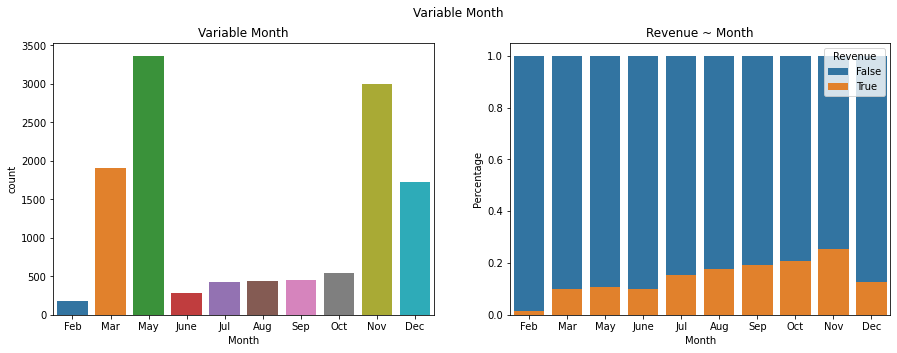


 CHI SQUARE TEST 

The p_value is 2.2387855164805443e-77 and therefore we can reject the null hypothesis that there is no significant relationship between Month and Revenue


In [13]:
#We will perform univariate and bivariate analysis with the target on the categorical variables.

categorical_analysis('Month', order=['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec'], palette='tab10')

We can have# several conclusions:

1.The data is not distributed in a balanced way during the months of the year. This may be a result of
#way of building the dataset or showing real trends (although differences are not likely if there is no other factor)

2. The conversion (The visits that end with purchase) is different between the months and we can see a general positive trend between
#February to November in conversion rate. (months March, May, June have more or less the same conversion).

3. We are missing data for January and April.

4. The chi-square test that checks the magnitude of the relationship between the independent variable and Revenue is significant.

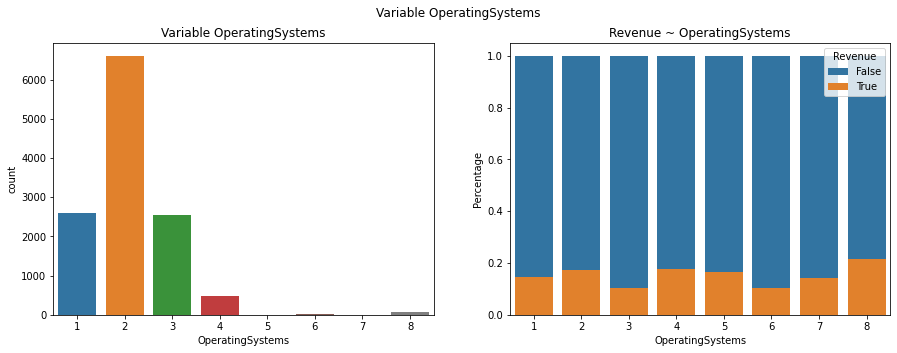


 CHI SQUARE TEST 

The p_value is 1.4160941129614401e-13 and therefore we can reject the null hypothesis that there is no significant relationship between OperatingSystems and Revenue


In [14]:
categorical_analysis('OperatingSystems')

In [15]:
#We can see that the categories of Operating systems are not balanced. Although the chi test is significant, we can have
#problem with minority categories:

data.OperatingSystems.value_counts()

2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

In [16]:
#Categories with few observations may not represent reality well because each observation in them gets a lot of weight.
#We will unite categories 6-7-5 in one:

data['Browser']=pd.Series(np.where(data.Browser.isin([7,12,11,9]), 'Other', data.Browser)).astype('category')

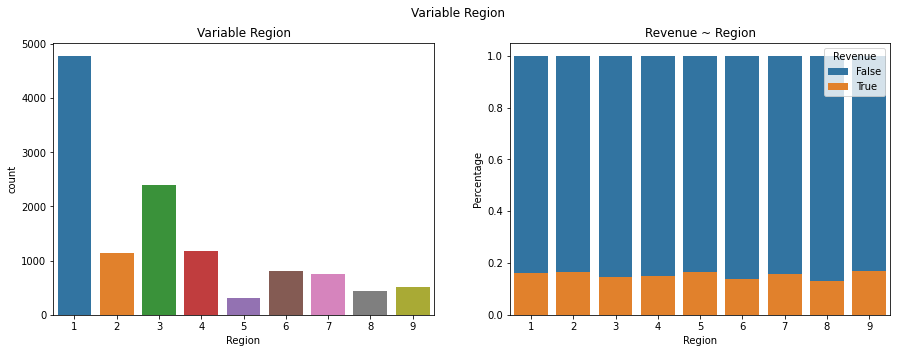


 CHI SQUARE TEST 

The p_value is 0.3214249979076556 and therefore we have to accept the null hypothesis that there is no significant relationship between Region and Revenue


In [17]:
categorical_analysis('Region')

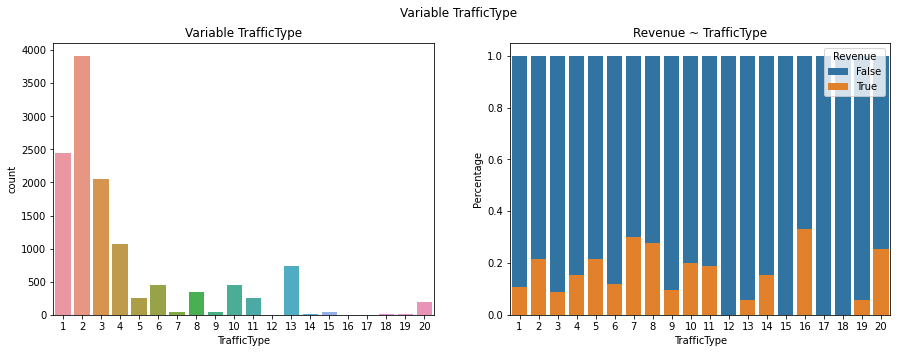


 CHI SQUARE TEST 

The p_value is 1.652735258160153e-67 and therefore we can reject the null hypothesis that there is no significant relationship between TrafficType and Revenue


In [18]:
#There is not much difference between the categories in bivariate analysis and also the chi-square test tells us
#(this variable is not statistically related to Revenue). The conclusion that this variable would not be a good predictor
# of revenue.


categorical_analysis('TrafficType')

In [19]:
#In general, the variable seems to be a good predictor but we still have to deal with minority categories that do not
#present statistically representative information.

data.TrafficType.value_counts()

2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64

In [20]:
#Let's convert the categories of less than 50 observations to one.

index=data.TrafficType.value_counts()[data.TrafficType.value_counts()<50].index

data.loc[:,'TrafficType']=pd.Series(np.where(data.TrafficType.isin(index), 'Other', data.TrafficType)).astype('category')

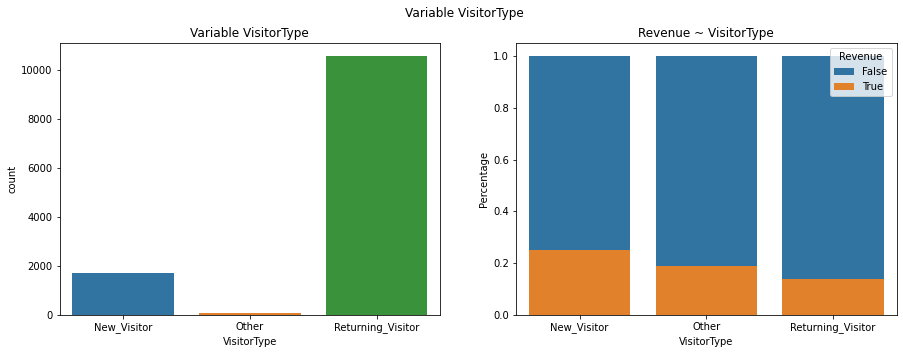


 CHI SQUARE TEST 

The p_value is 4.269904152293867e-30 and therefore we can reject the null hypothesis that there is no significant relationship between VisitorType and Revenue


Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [21]:
categorical_analysis('VisitorType')

data.VisitorType.value_counts() 

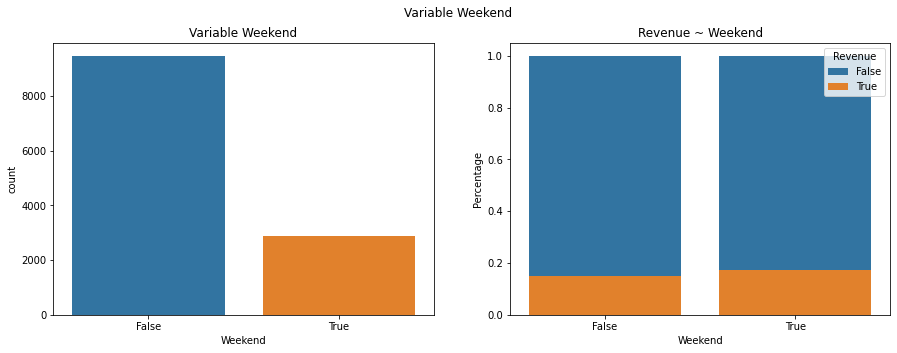


 CHI SQUARE TEST 

The p_value is 0.0012663251061221968 and therefore we can reject the null hypothesis that there is no significant relationship between Weekend and Revenue


False    9462
True     2868
Name: Weekend, dtype: int64

In [22]:
#Unbalanced variable but there seems to be a difference in conversion between categories. We'll leave 'Other' intact.

categorical_analysis('Weekend')

data.Weekend.value_counts() 

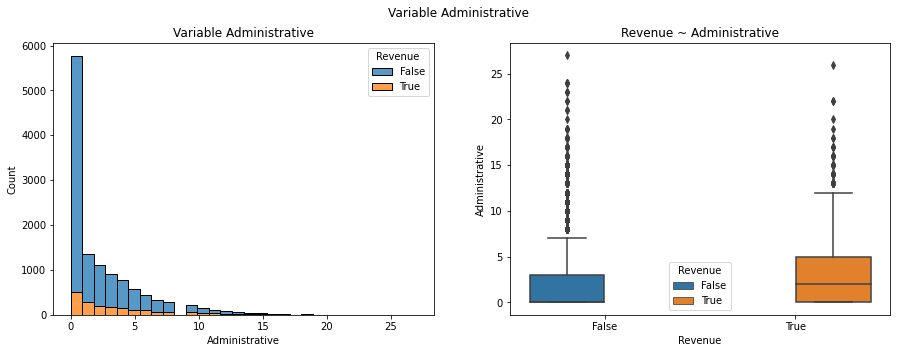


 The maximum value is 27 
 The minimum value is 0 


In [23]:
#La categoria de 'No weekend' es mas grande, lo que puede ser atribuido al hecho que cinco de los 7 días de la semana no son
#weekend. Sí existe diferencia pequeña en la tasa de conversión y el chi-test la detecta como significativa. Conclusión: 
#Hay relación entre las variables.


#Let´s start with numeric variables:

continuous_analysis('Administrative')

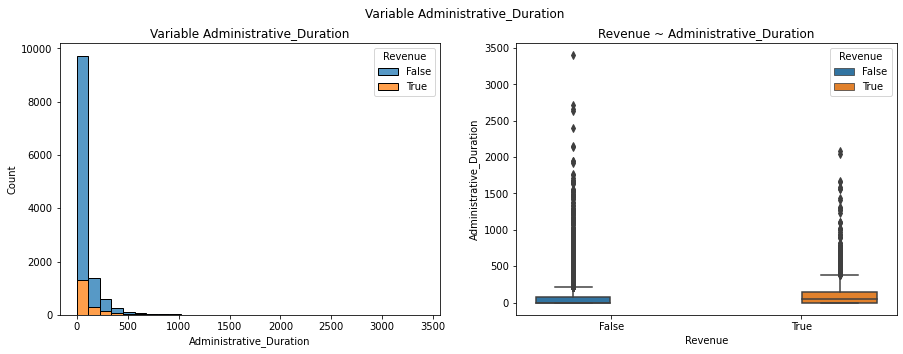


 The maximum value is 3398.75 
 The minimum value is 0.0 


In [24]:
#The distribution is not normal. Over half of the sessions had no administrative page views. The sessions finished
#in conversion (Revenue True) have considerably more visits to administrative pages.

continuous_analysis('Administrative_Duration')

In [25]:
#We have negative values ​​in duration which is not correct - duration cannot be negative. Let's see how many cases we have.

print(f'Number of observations with negative duration: {len(data[data.Administrative_Duration<0])}')

data[data.Administrative_Duration<0].head()

#We have 33 observations with negative values. The most probable that the observations that have value 0 in variable
#'Administrative' must have 0 in the duration and so we are going to impute. But we see that in other duration fields
#There are also negative values. Since there are only 33 observations, they constitute 0.003 of the dataset. We have enough data without
#these observations and we will delete them.

#The duration of the sessions can reach values of more than 3000 that at first glance may seem wrong but if
#we investigate more we understand that it is about seconds in Google analytics and that it can prove reality (for example when
#the session is inactive Google analytics keeps counting the time - by default up to half an hour of inactivity but it can be adjusted.)

Number of observations with negative duration: 0


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


In [26]:
data=data.drop(data[(data.Administrative_Duration<0)&(data.Informational_Duration<0)&(data.ProductRelated_Duration<0)].index).reset_index(drop=True)

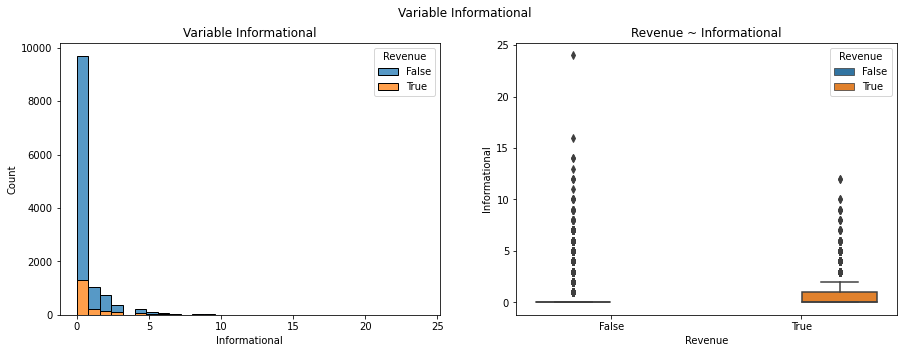


 The maximum value is 24 
 The minimum value is 0 


In [27]:
continuous_analysis('Informational')

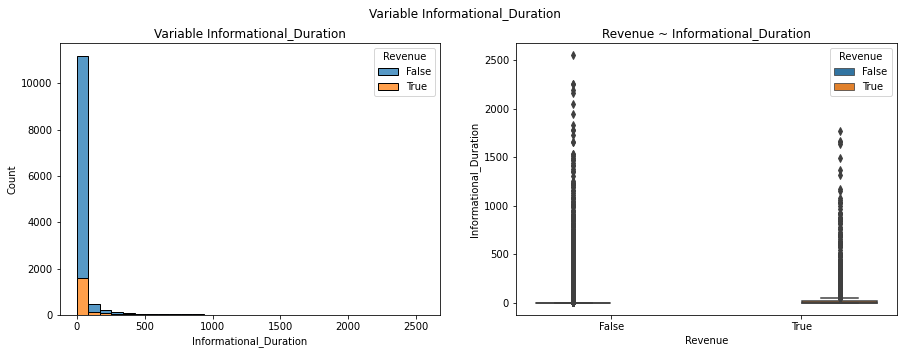


 The maximum value is 2549.375 
 The minimum value is 0.0 


In [28]:
#sessions with conversions have more informative pages if we consider the interquartile range (according to the x boxplots).

continuous_analysis('Informational_Duration', data=data)

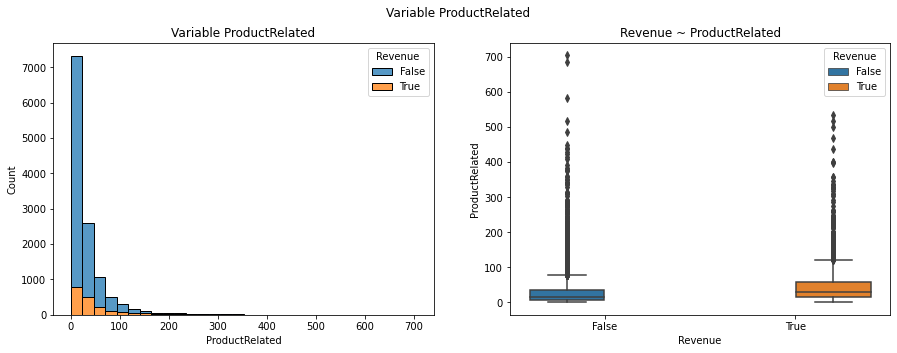


 The maximum value is 705 
 The minimum value is 0 


In [29]:
#We can see the same problem - very high outliers. As before, it can be explained by idle sessions.
#It also seems that this variable and the previous one are highly correlated. We will see later if there is multicollinearity.

continuous_analysis('ProductRelated') 

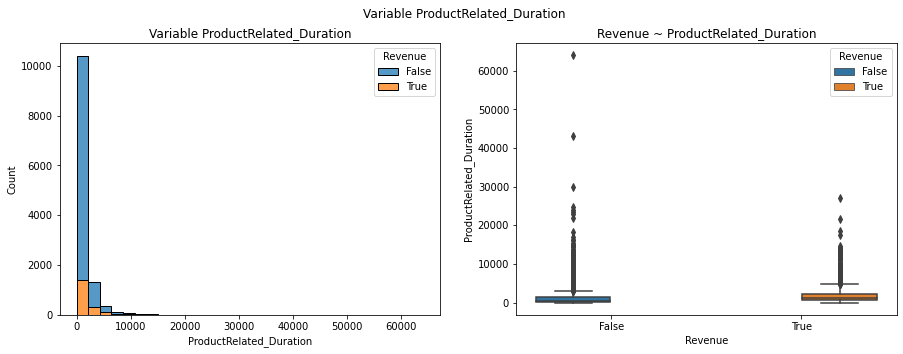


 The maximum value is 63973.52223 
 The minimum value is 0.0 


In [30]:
#Interesting situation in 'extreme' sessions, with many page views. It seems that sessions without conversion have medians
#highest number of page views. Searched for a product and have not found it?
#This trend is inverse to what happens below 200 page views.

continuous_analysis('ProductRelated_Duration')

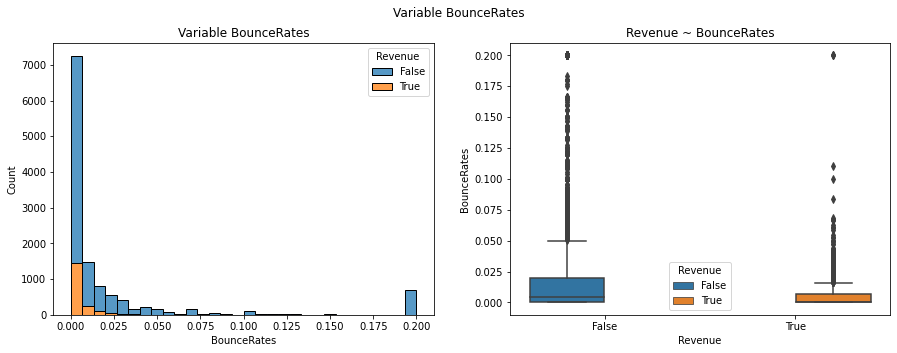


 The maximum value is 0.2 
 The minimum value is 0.0 


In [31]:
#We see very high values. But without knowing the subject well (knowing the domain and conditions configured in analytics by the company
#wouldn't delete these extreme cases of outliers. It may be that they are real situations - sessions not closed for a long time.
#We have to be very safe to delete or transform oultliers.)

continuous_analysis('BounceRates')

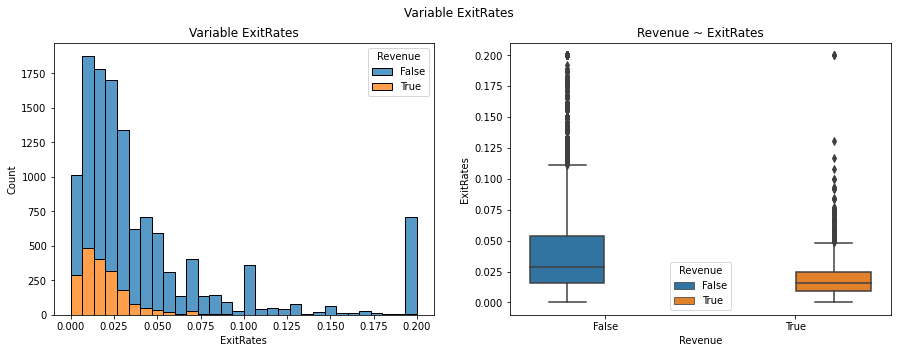


 The maximum value is 0.2 
 The minimum value is 0.0 


In [32]:
#It makes sense that there will be more conversions where the landing page has a lower bounce rate. This is what we see in the boxplots.


continuous_analysis('ExitRates')

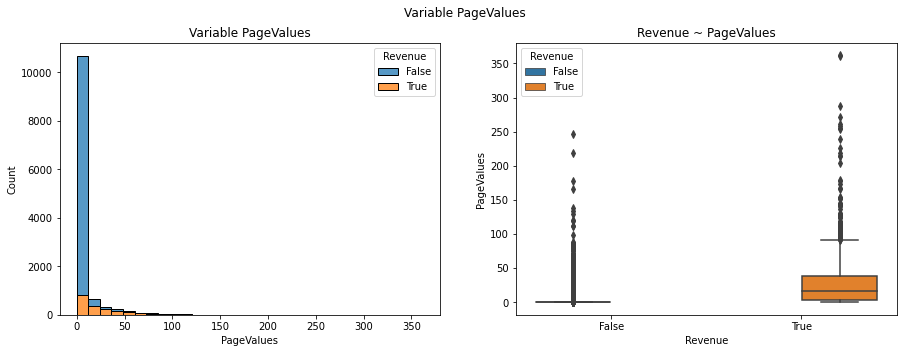


 The maximum value is 361.7637419 
 The minimum value is 0.0 


In [33]:
#If I understand correctly, the 'Exit Rate' metric in this case speaks of the average 'ExitRates' of the pages visited during the
#session. If so, it also makes sense for less interesting/popular/higher Exit Rate pages to convert less.
#In other words, people who visit pages with high Exit Rates are less likely to make purchases.

continuous_analysis('PageValues')

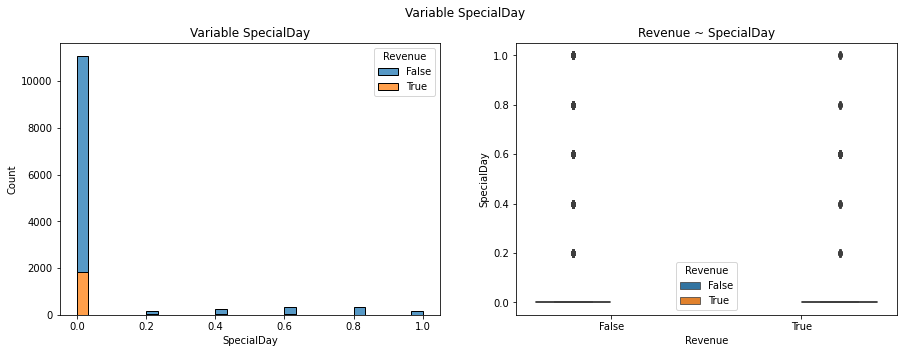


 The maximum value is 1.0 
 The minimum value is 0.0 


In [34]:
#The highest values ​​have to be related to checkout pages. These pages tend to have high values ​​because all conversions
#go through them page. This is why we see more conversion in sessions with high PageValues. How we explain outliers without conversion
#high values ​​of PageValues? They are probably those who reached checkout pages but ended up
#the process and they did not finish it. Most likely the 'PageValue' variable here refers to the sum of the 'PageValues' of the visited pages.
#If so, the inclusion of checkout pages does not have much value in predicting future conversion.
#But we don't know for sure how they counted the PageValue metric for the whole session and we will consider this variable
#for final analysis.

continuous_analysis('SpecialDay')

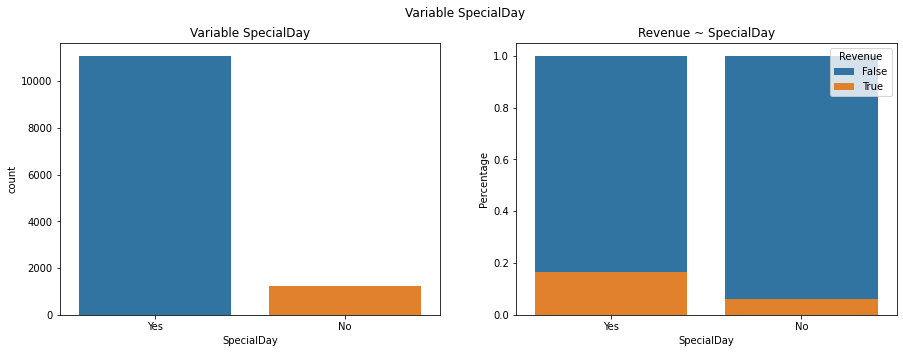


 CHI SQUARE TEST 

The p_value is 1.0317417596405984e-21 and therefore we can reject the null hypothesis that there is no significant relationship between SpecialDay and Revenue


In [35]:
#This variable seems to be a good candidate to categoricals. It has only 6 different values (We have checked it at the beginning).
#Let's split it into two categories: 'yes' for 'Special day' days and 'no' for the others(0.2-> 1)

data['SpecialDay']=pd.cut(data['SpecialDay'], bins=[-1,0.1,1.1], labels=['Yes','No'])

categorical_analysis('SpecialDay')

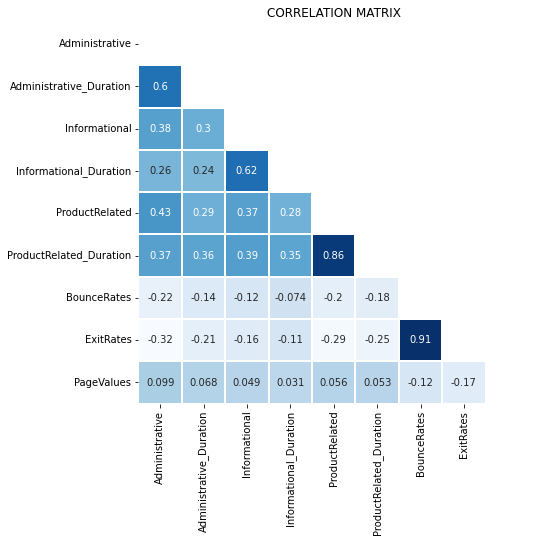

In [36]:
#Conclusions -we have much more observations of special days. Special days usually have higher conversion and it is
#statistically significant.

#Let´s examine now the correlation between the numerical variables:

mask = np.triu(np.ones_like(data.corr()))
plt.figure(figsize=(7,7))
sns.heatmap(data.corr(), annot=True, mask=mask, cmap='Blues', xticklabels=data.select_dtypes(exclude='category').columns[:-1]\
           ,yticklabels='auto', linewidths=.1, cbar=False)
np.fill_diagonal(mask, True)
plt.title('CORRELATION MATRIX')
plt.show()

In [37]:
#We have high correlation in case of 4 variables. We will check multicollinearity.

numeric=data.select_dtypes(exclude='category')

VIF=pd.DataFrame()
VIF['variables']=numeric.columns
VIF['values']=[variance_inflation_factor(numeric.values, column) for column in range(len(numeric.columns))]
VIF

,variables,values
0,Administrative,2.650789
1,Administrative_Duration,2.041793
2,Informational,2.113500
3,Informational_Duration,1.777152
4,ProductRelated,6.309248
5,ProductRelated_Duration,6.007085
6,BounceRates,5.483943
7,ExitRates,5.715925
8,PageValues,1.077639


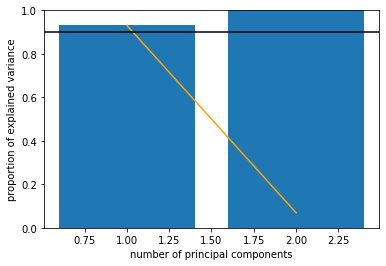

In [38]:
#Clearly we have a problem with variables with a VIF value higher than 5. But also other variables that measure the same concept
#slightly differently have high correlation - 'administrative duration'/'administrative', 'Informational duration/informational'

#Maybe we can reduce the number of variables by principal component analysis. Preventing multicollinearity is good
#practice although it is not necessary for predictions (yes for interpretation). In addition we want models that are simpler, with less
#dimensions.


#First we scale the data to prepare it for PCA:

scaler=StandardScaler()
norm=pd.DataFrame()
norm[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']]\
=scaler.fit_transform(data[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']])

pca=PCA()
pca.fit(norm[['ProductRelated','ProductRelated_Duration',]])


#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [39]:
#We see that with one variable we can explain more than 90% of the variance of the two original variables.


pca=PCA(n_components=1)
norm['Product_Related_PCA']=pca.fit_transform(norm[['ProductRelated','ProductRelated_Duration']])

norm=norm.drop(['ProductRelated','ProductRelated_Duration'],axis=1)

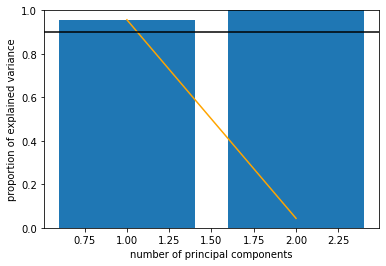

In [40]:
pca2=PCA()
pca2.fit(norm[['BounceRates','ExitRates']])

#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca2.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [41]:
#We see that with one variable we can explain more than 95% of the variance of the two original variables.

pca2=PCA(n_components=1)

norm['Bounce_Exit_PCA']=pca2.fit_transform(norm[['BounceRates','ExitRates']])

norm=norm.drop(['BounceRates','ExitRates'],axis=1)

In [42]:
#Unite the new variables with other continuous ones and scale.

numeric=numeric.drop(['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates'],axis=1)
numeric[['Product_Related_PCA','Bounce_Exit_PCA' ]]=norm

#To improve the results, it will be necessary to transform the data so that they have a distribution that is as close as possible to a
#normal. Although our data is very problematic in this regard (lots of '0' values ​​and also outliers).
#to a normal one but we will still improve the predictive power of algorithms such as regression. In this case we will use the 'Yeo-Johnson' method.
#Transformation also helps with outliers.

columns=numeric.columns

trans=PowerTransformer(standardize=False)
numeric_trans=trans.fit_transform(numeric)

#We normalize between 0 and 1 (we obtain better results in our particular case with the data we have)

minmax=MinMaxScaler()
numeric_scaled=pd.DataFrame(minmax.fit_transform(numeric_trans), columns=columns)


In [43]:
#One-Hot Encoding

cat=pd.get_dummies(data.select_dtypes(include='category'), drop_first=True)

In [44]:
#Concatenating numeric and categorical data back

df=pd.concat([cat, numeric_scaled], axis=1)

y=df.Revenue_True
X=df.drop('Revenue_True', axis=1)

X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=1)

In [45]:
#Let's start adjusting models. We will start with a linear model (as stipulated in the exercise) of logistic regression,
#calibrate the best hyperparameters through exhaustive search with GridSearch. GridSearch will evaluate each combination
#with cross-validation and it will return the best parameters and their respective cross-validation score (mean of Folds scores)

regr=LogisticRegression()

params={'C':[0.8,0.9,1],'class_weight':['balanced'], 'max_iter':[100,200]}

model_log=GridSearchCV(regr,params,cv=6, scoring='roc_auc') #usamos el StratiifiedKFold (por defecto)

model_log.fit(X_train, y_train)
print(f'The best model parameters are: {model_log.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the logistic regression is {model_log.best_score_}')

The best model parameters are: {'C': 0.8, 'class_weight': 'balanced', 'max_iter': 100} 

Mean Cross Validation Roc AUC score of the logistic regression is 0.9157902458997621


In [46]:
#We will try Random Forest now

forest=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)

#Random Forest does not require as much data preparation as linear models. You only need numerical data (categorical variables
# have to be encoded). Therefore we will try to fit the model with 'almost original' data - from before dimensional reduction.
#Later we will also adjust with the same regression data and see where we had better performance.

data=data.drop('Revenue', axis=1)
categ=pd.DataFrame()

#We encode the categoricals differently (similar to LabelEncoder())

for i in data.select_dtypes(include='category').columns:
    categ[i]=pd.factorize(data[i])[0]

df=pd.concat([categ,data.select_dtypes(exclude='category')], axis=1)

X_train2, X_test2, y_train2, y_test2=train_test_split(df, y, train_size=0.8, random_state=1)



model_forest.fit(X_train2, y_train2)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 13, 'min_samples_leaf': 3} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9031832927818328


In [47]:
#We will try with the fully transformed data (same input as in logistic regression)

forest2=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)

model_forest.fit(X_train, y_train)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 13, 'min_samples_leaf': 3} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9015612327656125


In [48]:
#We can see the cross-validation result obtained for Random Forest is almost similar for"original" and transformed data.

In [49]:
#Now we will implement the deep learning model. We will use Keras and configure the parameters through GridSearchCV
#using Keras wrapper for ScikitLearn API

#Construction of the model:

def deep_model_compile(optimizer='Adam', dropout=0.1): 
    
    model=Sequential()
    model.add(Dense(30, activation='relu',input_shape=(X_train.shape[1],),activity_regularizer=regularizers.L2(0.001)))
    model.add(Dense(30, activation='relu',activity_regularizer=regularizers.L2(0.001)))
    model.add(Dense(30, activation='relu',activity_regularizer=regularizers.L2(0.001)))
    model.add(Dropout(dropout), )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='AUC')
    return model

In [50]:
#we want to use early stop regularization to prevent overfitting

callback=EarlyStopping(monitor='auc',min_delta=0.01, patience=5)

#parameters to examine:

params={'callbacks':[callback],
    'epochs': [30],
    'batch_size':[100, 25],
    'optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd']}

#initialization of the wrapper
classify= KerasClassifier(build_fn=deep_model_compile)

deep_model=GridSearchCV(classify, params, cv=6, scoring='roc_auc')

In [51]:
deep_model.fit(X_train, y_train)

2022-06-25 18:40:15.031769: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-25 18:40:15.262233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
83/83 [==============================] - 2s 3ms/step - loss: 0.4415 - auc: 0.6734
Epoch 2/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2916 - auc: 0.8937
Epoch 3/30
83/83 [==============================] - 0s 4ms/step - loss: 0.2700 - auc: 0.9117
Epoch 4/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2605 - auc: 0.9177
Epoch 5/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2543 - auc: 0.9219
Epoch 6/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2473 - auc: 0.9273
Epoch 1/30
83/83 [==============================] - 1s 3ms/step - loss: 0.4084 - auc: 0.7419
Epoch 2/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2970 - auc: 0.8908
Epoch 3/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2759 - auc: 0.9069
Epoch 4/30
83/83 [==============================] - 0s 3ms/step - loss: 0.2657 - auc: 0.9161
Epoch 5/30
83/83 [==============================] - 0s 3ms/step - loss

GridSearchCV(cv=6,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6fa739dad0>,
             param_grid={'batch_size': [100, 25],
                         'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f6fa74622d0>],
                         'epochs': [30],
                         'optimizer': ['RMSprop', 'Adam', 'Adamax', 'sgd']},
             scoring='roc_auc')

In [52]:
#Best Parameters
deep_model.best_params_

{'batch_size': 100,
 'callbacks': <keras.callbacks.EarlyStopping at 0x7f6fa74622d0>,
 'epochs': 30,
 'optimizer': 'Adam'}

In [53]:
#Best CrossValidation result (across all folds)
deep_model.best_score_

0.9239658853424793

#We see that the neural network model has the highest cross-validation score. Second the logistic regression and then
#Random Forest.

#We will implement the prediction and we will do it with the GridSearch (you don't have to train again because it is already trained with
#all data - 'refit' parameter is 'True' by default.)

In [54]:
#Our score for the test.

prob_test=deep_model.predict_proba(X_test)

roc_auc_score(y_test, prob_test[:,1])

0.9292753564621176

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

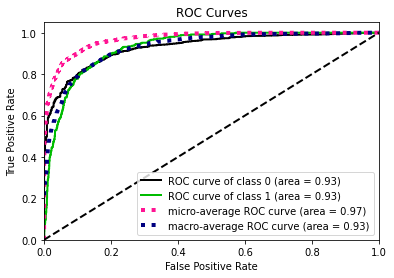

In [55]:
#ROC AUC plot

plot_roc(y_test, prob_test)

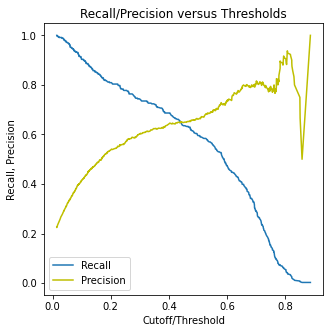

In [56]:
#ROC AUC takes into account the negative (0) class
#and in unbalanced datasets like ours the inclusion of negative class (majority according to number of observations)
#presents overoptimistic result.
#In our case it would be better to take into account the balance between Recall (sensitivity) and Precision.
# We try to predict the maximum of positive class (sensitivity) but at the same time trying not to harm the precision
#(no use of negative class total in denominator in precision calculation)


precision,recall,thresholds=precision_recall_curve(y_test, prob_test[:,1])

metrics=pd.DataFrame(np.column_stack([precision[:-1],recall[:-1],thresholds]), columns=['Precision','Recall','Thresholds'])



plt.figure(figsize=(5,5))
plt.plot(metrics.Thresholds,metrics.Recall,  label='Recall')
plt.plot(metrics.Thresholds,metrics.Precision,  c='y', label='Precision')
plt.ylabel('Recall, Precision')
plt.xlabel('Cutoff/Threshold')
plt.title('Recall/Precision versus Thresholds')
plt.legend(loc=3)
plt.show()

In [57]:
#Choosing the cutoff at the crosspoint of precision and recall can be an option.

cutoff=metrics.loc[np.abs(metrics.Recall-metrics.Precision)==np.abs(metrics.Recall-metrics.Precision).min(),'Thresholds']

classes=np.where(prob_test[:,1]>=cutoff.values,1,0)

In [58]:
print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2115
           1       0.65      0.65      0.65       351

    accuracy                           0.90      2466
   macro avg       0.80      0.80      0.80      2466
weighted avg       0.90      0.90      0.90      2466



<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

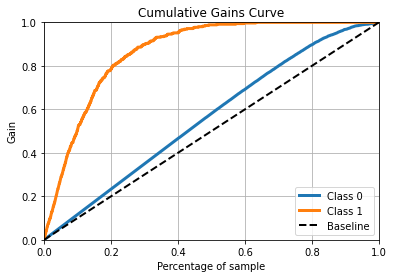

In [59]:
#We can also decide on the threshold in another way, taking into account the Recall or maximizing positive cases
#minimizing the sample size. For example, if among 10,000 new unclassified clients we want to send a campaign of
# marketing only at 2000 (20%) we can place the threshold at the 80th percentile (20% higher in the vector of probabilities).
#Using the following graph we can see that we can achieve more or less 76% positives from the total positives in
#the 10000

plot_cumulative_gain(y_test, prob_test)

In [60]:
percentile=np.percentile(prob_test[:,1], 80)

classes=np.where(prob_test[:,1]>=percentile,1,0)

print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2115
           1       0.56      0.79      0.65       351

    accuracy                           0.88      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.88      0.89      2466

